Load the Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os

         ImageId                                      EncodedPixels
0  00003e153.jpg                                                NaN
1  0001124c7.jpg                                                NaN
2  000155de5.jpg  264661 17 265429 33 266197 33 266965 33 267733...
3  000194a2d.jpg  360486 1 361252 4 362019 5 362785 8 363552 10 ...
4  000194a2d.jpg  51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...


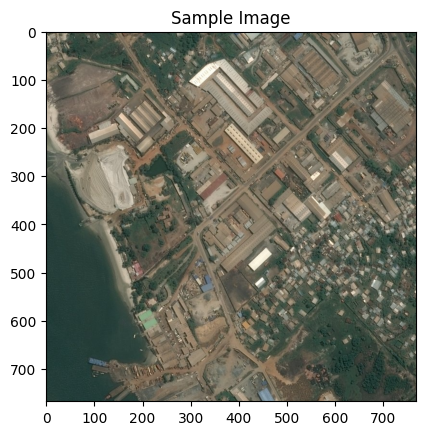

In [5]:
# Load the CSV file
train_df = pd.read_csv('../data/train_ship_segmentations_v2.csv')
print(train_df.head())

# Load a sample image
sample_image = cv2.imread('../data/train_v2/00021ddc3.jpg')
plt.imshow(cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB))
plt.title('Sample Image')
plt.show()

Basic Data Information

In [6]:
print(f"Number of images: {train_df['ImageId'].nunique()}")
print(f"Number of entries: {train_df.shape[0]}")
print(train_df.info())

Number of images: 192556
Number of entries: 231723
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 231723 entries, 0 to 231722
Data columns (total 2 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   ImageId        231723 non-null  object
 1   EncodedPixels  81723 non-null   object
dtypes: object(2)
memory usage: 3.5+ MB
None


Distribution of Ships per Image

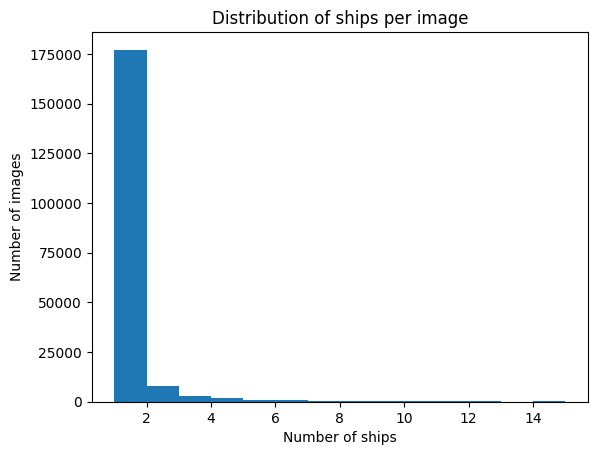

In [7]:
ships_per_image = train_df.groupby('ImageId').size()
plt.hist(ships_per_image, bins=range(1, ships_per_image.max() + 1))
plt.xlabel('Number of ships')
plt.ylabel('Number of images')
plt.title('Distribution of ships per image')
plt.show()


Mask Analysis

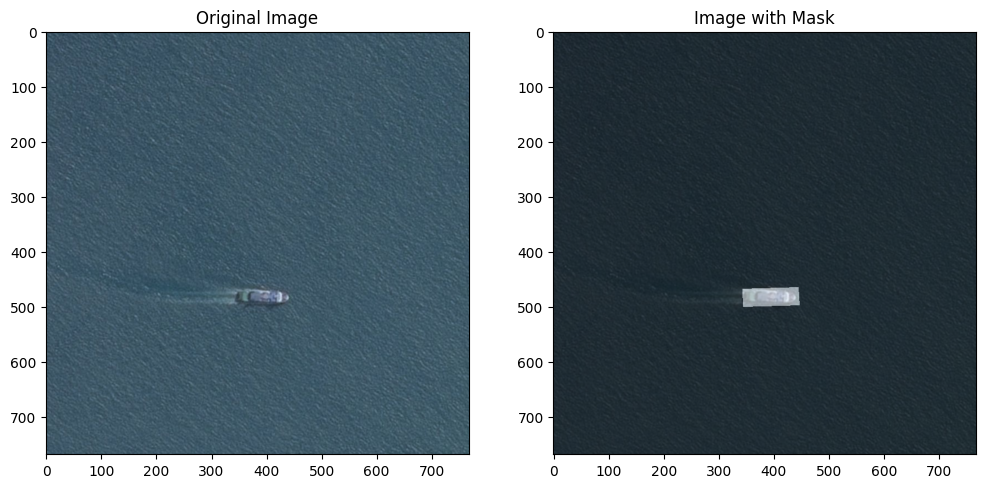

In [32]:
import numpy as np

def rle_decode(mask_rle, shape=(768, 768)):
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0::2], s[1::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0] * shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T



import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os

# Load the CSV file
train_df = pd.read_csv('../data/train_ship_segmentations_v2.csv')

# Select a sample image with a mask
sample_entry = train_df.dropna(subset=['EncodedPixels']).iloc[0]
image_id = sample_entry['ImageId']
mask_rle = sample_entry['EncodedPixels']
image_path = f'../data/train_v2/{image_id}'

# Load the image
image = cv2.imread(image_path)

if image is not None:
    # Decode the mask
    mask = rle_decode(mask_rle)

    # Plot the image and mask
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    # Display the original image
    axs[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    axs[0].set_title('Original Image')

    # Display the mask overlaid on the image
    axs[1].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    axs[1].imshow(mask, alpha=0.5, cmap='gray')
    axs[1].set_title('Image with Mask')

    plt.show()
else:
    print(f"Error: Image at path {image_path} could not be loaded.")


Image Size and Aspect Ratio

Processing images: 100%|██████████| 192556/192556 [07:44<00:00, 414.31image/s]


Processed 192556 images.


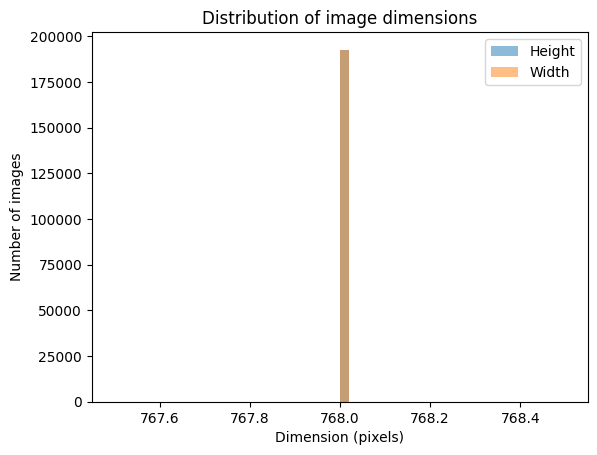

In [37]:
image_dir = '../data/train_v2/'



import os
import cv2
from tqdm import tqdm

# Define the image directory
image_dir = '../data/train_v2/'

# Get a list of all image files in the directory
image_files = os.listdir(image_dir)

# Initialize an empty list to store image shapes
image_shapes = []

# Loop through image files with a progress bar
for img in tqdm(image_files, desc="Processing images", unit="image"):
    image_path = os.path.join(image_dir, img)
    image = cv2.imread(image_path)

    if image is not None:
        image_shapes.append(image.shape)
    else:
        print(f"Warning: Image at path {image_path} could not be loaded.")

# Output the results
print(f"Processed {len(image_shapes)} images.")

heights, widths, _ = zip(*image_shapes)

plt.hist(heights, bins=50, alpha=0.5, label='Height')
plt.hist(widths, bins=50, alpha=0.5, label='Width')
plt.xlabel('Dimension (pixels)')
plt.ylabel('Number of images')
plt.title('Distribution of image dimensions')
plt.legend()
plt.show()


Missing Data 

In [11]:
missing_data = train_df.isnull().sum()
print(missing_data[missing_data > 0])

EncodedPixels    150000
dtype: int64


Ship Size Distribution

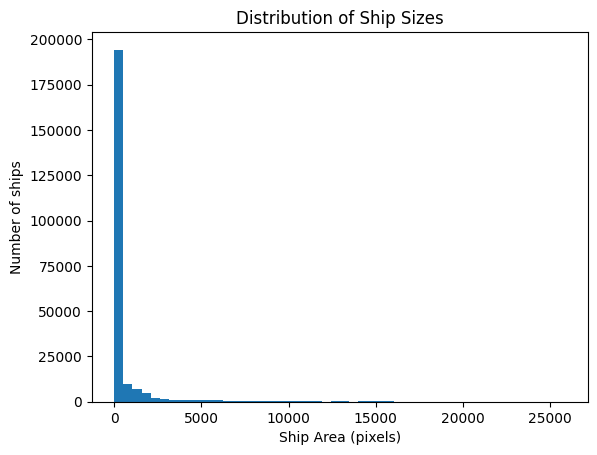

In [12]:
def mask_area(mask_rle):
    mask = rle_decode(mask_rle)
    return np.sum(mask)

train_df['ShipArea'] = train_df['EncodedPixels'].apply(mask_area)

plt.hist(train_df['ShipArea'], bins=50)
plt.xlabel('Ship Area (pixels)')
plt.ylabel('Number of ships')
plt.title('Distribution of Ship Sizes')
plt.show()


Image Augmentation Visualization

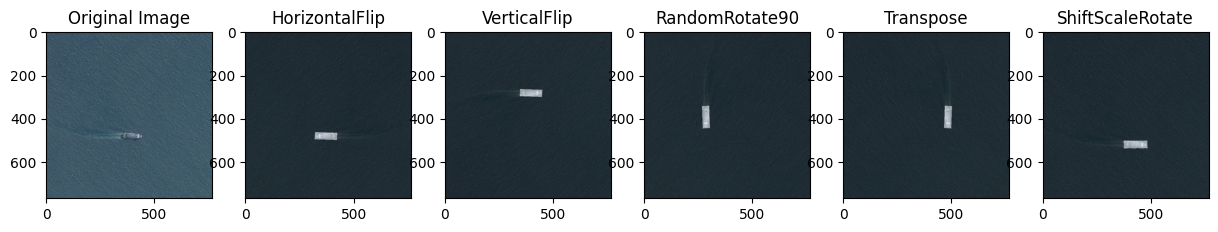

In [34]:
# Load the CSV file
train_df = pd.read_csv('../data/train_ship_segmentations_v2.csv')

# Filter out rows with NaN values in EncodedPixels
train_df = train_df.dropna(subset=['EncodedPixels'])

# Function to decode RLE
def rle_decode(mask_rle, shape=(768, 768)):
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0::2], s[1::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0] * shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T


from albumentations import (
    HorizontalFlip, VerticalFlip, RandomRotate90, Transpose, ShiftScaleRotate
)

# Define augmentations
aug = [HorizontalFlip(p=1), VerticalFlip(p=1), RandomRotate90(p=1), Transpose(p=1), ShiftScaleRotate(p=1)]

# Select a sample image with a mask
sample_entry = train_df.iloc[0]
image_id = sample_entry['ImageId']
mask_rle = sample_entry['EncodedPixels']
image_path = f'../data/train_v2/{image_id}'

# Load the image
image = cv2.imread(image_path)

if image is not None:
    # Decode the mask
    mask = rle_decode(mask_rle)

    # Plot the image and mask
    fig, axs = plt.subplots(1, len(aug) + 1, figsize=(15, 5))

    # Display the original image
    axs[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    axs[0].set_title('Original Image')

    # Apply augmentations and visualize
    for i, a in enumerate(aug):
        augmented = a(image=image, mask=mask)
        axs[i + 1].imshow(cv2.cvtColor(augmented['image'], cv2.COLOR_BGR2RGB))
        axs[i + 1].imshow(augmented['mask'], alpha=0.5, cmap='gray')
        axs[i + 1].set_title(a.__class__.__name__)

    plt.show()
else:
    print(f"Error: Image at path {image_path} could not be loaded.")


Mask Coverage Analysis

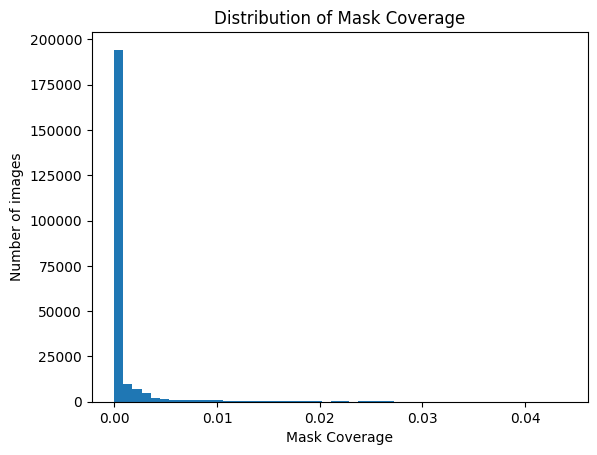

In [13]:
def mask_coverage(mask_rle):
    mask = rle_decode(mask_rle)
    return np.sum(mask) / (mask.shape[0] * mask.shape[1])

train_df['MaskCoverage'] = train_df['EncodedPixels'].apply(mask_coverage)

plt.hist(train_df['MaskCoverage'], bins=50)
plt.xlabel('Mask Coverage')
plt.ylabel('Number of images')
plt.title('Distribution of Mask Coverage')
plt.show()


Ship Position Analysis

/Users/nazarii_mozol/projects/studing/test task/venv/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/nazarii_mozol/projects/studing/test task/venv/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


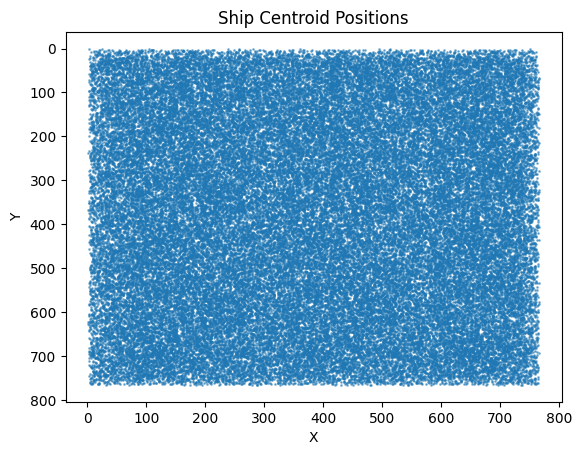

In [14]:
def mask_centroid(mask_rle):
    mask = rle_decode(mask_rle)
    y, x = np.nonzero(mask)
    return np.mean(x), np.mean(y)

train_df['Centroid'] = train_df['EncodedPixels'].apply(mask_centroid)
centroids = np.array(train_df['Centroid'].tolist())

plt.scatter(centroids[:, 0], centroids[:, 1], alpha=0.5, s=1)
plt.gca().invert_yaxis()
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Ship Centroid Positions')
plt.show()


Correlation Analysis

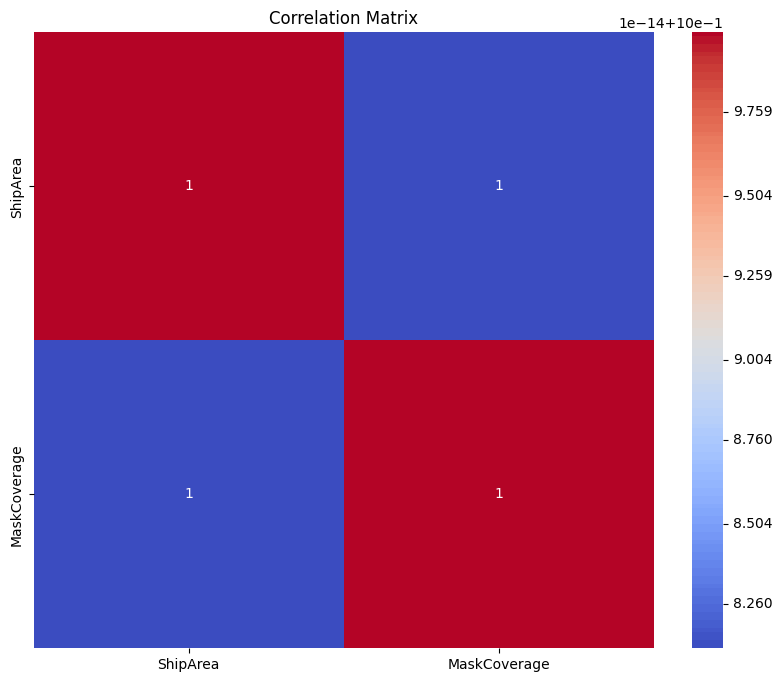

In [18]:
# Filter out non-numeric columns
numeric_df = train_df.select_dtypes(include=[np.number])

# Compute the correlation matrix
corr = numeric_df.corr()

# Visualize the correlation matrix
import seaborn as sns
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()


Heatmap of Ship Positions

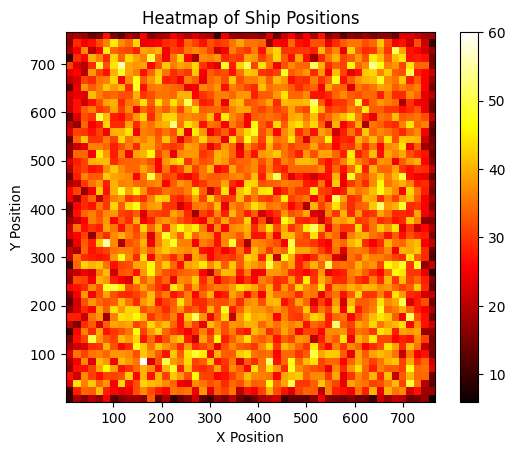

In [35]:
heatmap, xedges, yedges = np.histogram2d(centroids[:, 0], centroids[:, 1], bins=(50, 50))
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

plt.imshow(heatmap.T, extent=extent, origin='lower', cmap='hot', interpolation='nearest')
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.title('Heatmap of Ship Positions')
plt.colorbar()
plt.show()
